<a href="https://colab.research.google.com/github/SJinLee/XAI2023/blob/main/x2.explainable2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* google drive에 연결
from google

In [ ]:
# from google.colab import drive
# drive.mount('/drive')

In [ ]:
!rm -r train valid
!unzip drive/MyDrive/xai/car_or_truck.zip > /dev/null

In [ ]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

In [ ]:
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")

In [ ]:
ds_train_ = image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [ ]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
!rm -rf cv-course-models
!unzip drive/MyDrive/xai/base_models.zip > /dev/null

In [ ]:
pretrained_base = tf.keras.models.load_model(
    'cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
checkpoint_filepath = 'save/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=1,
    callbacks=[model_checkpoint_callback],
)

model.load_weights(checkpoint_filepath)

Epoch 1/30
80/80 [==============================] - 16s 184ms/step - loss: 0.5501 - binary_accuracy: 0.7315 - val_loss: 0.4533 - val_binary_accuracy: 0.7973
Epoch 2/30
80/80 [==============================] - 14s 176ms/step - loss: 0.4109 - binary_accuracy: 0.8222 - val_loss: 0.3891 - val_binary_accuracy: 0.8349
Epoch 3/30
80/80 [==============================] - 13s 168ms/step - loss: 0.3555 - binary_accuracy: 0.8544 - val_loss: 0.3596 - val_binary_accuracy: 0.8476
Epoch 4/30
80/80 [==============================] - 13s 166ms/step - loss: 0.3198 - binary_accuracy: 0.8708 - val_loss: 0.3411 - val_binary_accuracy: 0.8535
Epoch 5/30
80/80 [==============================] - 13s 165ms/step - loss: 0.2917 - binary_accuracy: 0.8884 - val_loss: 0.3281 - val_binary_accuracy: 0.8596
Epoch 6/30
80/80 [==============================] - 13s 167ms/step - loss: 0.2679 - binary_accuracy: 0.8980 - val_loss: 0.3189 - val_binary_accuracy: 0.8636
Epoch 7/30
80/80 [==============================] - 13s 16

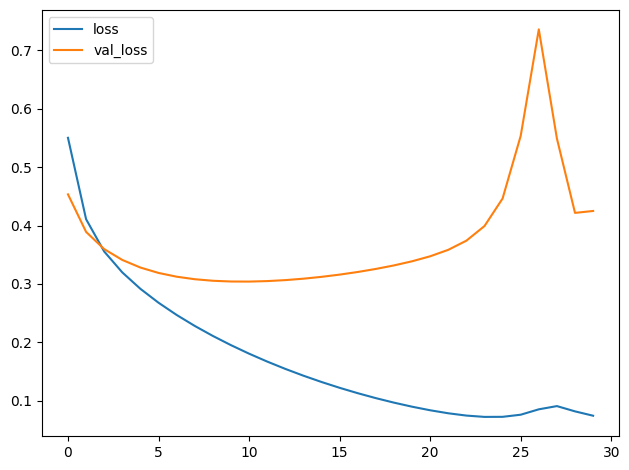

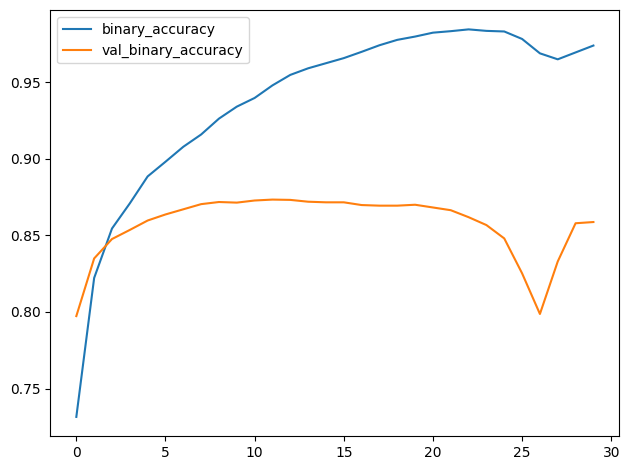

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
pred = model.predict(ds_valid)

79/79 [==============================] - 6s 81ms/step


In [ ]:
pred

array([[0.00106255],
       [0.00435413],
       [0.1211395 ],
       ...,
       [0.8717226 ],
       [0.91883993],
       [0.9943704 ]], dtype=float32)

In [ ]:
label = np.concatenate([x[1].numpy() for x in ds_valid])
label

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
(pred>0.5)*1==label

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
((pred>0.5)*1==label).mean()

0.8726984755493962

In [ ]:
imgs = [x[0].numpy() for x in ds_valid]
img = imgs[0][0]

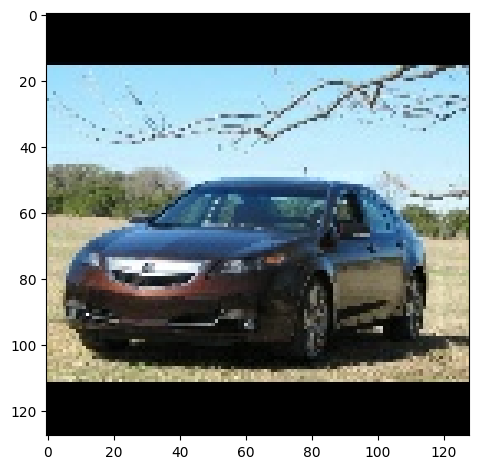

In [ ]:
plt.imshow(img)

In [ ]:
img.min(),img.max()

(0.0, 1.0)

In [ ]:
model.predict(img[np.newaxis,:,:,:])

1/1 [==============================] - 0s 52ms/step


array([[0.00106255]], dtype=float32)

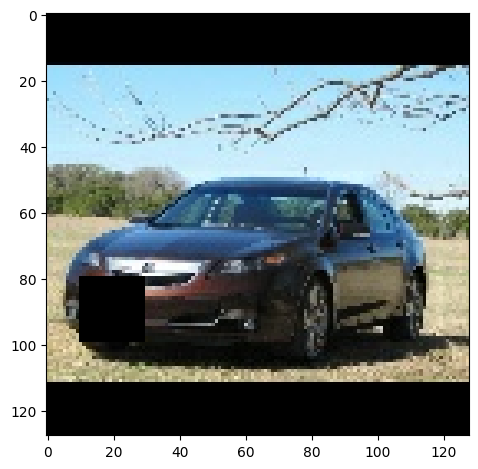

In [ ]:
img_damaged = img.copy()
img_damaged[80:100,10:30,:] = 0
plt.imshow(img_damaged)

In [ ]:
model.predict(img_damaged[np.newaxis,:,:,:])

1/1 [==============================] - 0s 31ms/step


array([[0.00121085]], dtype=float32)

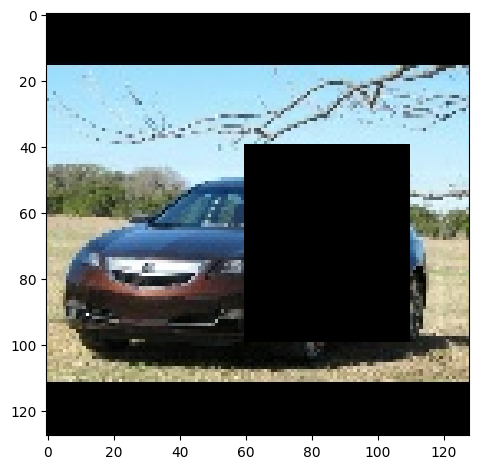

In [ ]:
img_damaged = img.copy()
img_damaged[40:100,60:110,:] = 0
plt.imshow(img_damaged)

In [ ]:
model.predict(img_damaged[np.newaxis,:,:,:])

1/1 [==============================] - 0s 69ms/step


array([[0.09276895]], dtype=float32)

1/1 [==============================] - 0s 33ms/step


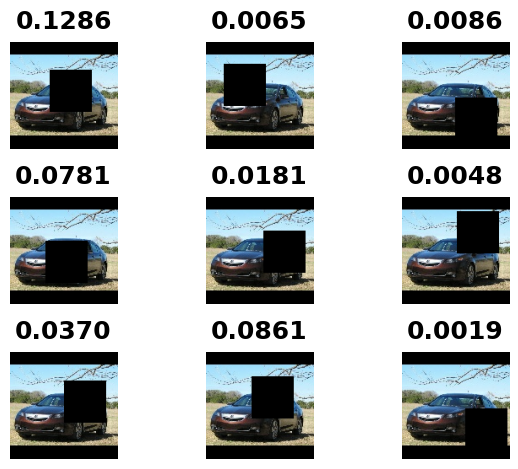

In [ ]:
for i in range(9):
    x,y = (np.random.random(2)*(128-50)).round(0).astype(int)
    img_damaged = img.copy()
    img_damaged[y:y+50,x:x+50,:] = 0
    pred = model.predict(img_damaged[np.newaxis,:,:,:])
    plt.subplot(3,3,i+1)
    plt.imshow(img_damaged)
    plt.axis('off')
    plt.title(f'{pred[0][0]:.4f}')

    # break
plt.show()

In [ ]:
from keras.utils import load_img
# load the image with the required shape
img = load_img('/content/valid/Car/05138.jpeg', target_size=(128, 128))
from keras.utils import img_to_array
from tensorflow import expand_dims
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
img = img / 255

In [ ]:
img.numpy().max(),img.numpy().min()

(1.0, 0.0)

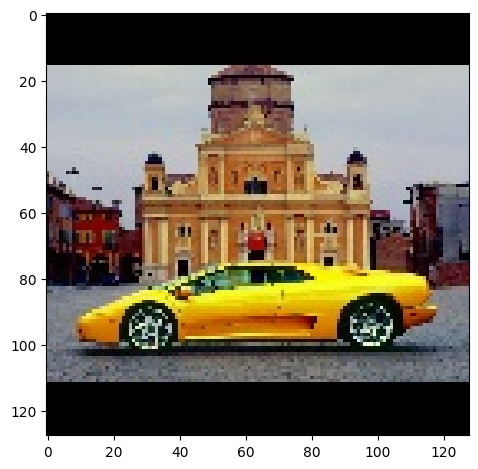

In [ ]:
img_plot = img[0,:,:,:].numpy()
plt.imshow(img_plot)

In [ ]:
model.predict(img)

1/1 [==============================] - 0s 201ms/step


array([[0.00290822]], dtype=float32)

In [ ]:
img_numpy = img.numpy()
img_numpy[:,80:100,10:30,:] = 0

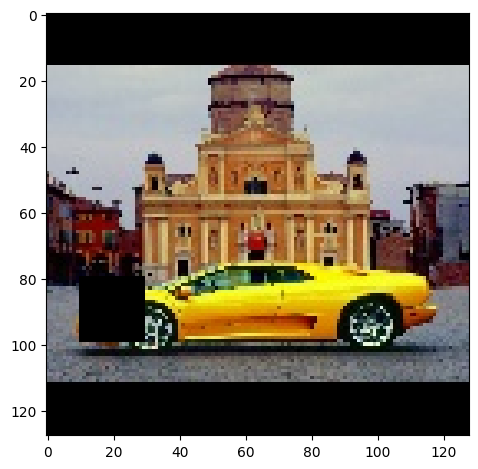

In [ ]:
plt.imshow(img_numpy[0,:,:,:])

In [ ]:
model.predict(img_numpy)

1/1 [==============================] - 0s 29ms/step


array([[0.0022373]], dtype=float32)

1/1 [==============================] - 0s 29ms/step


array([[0.13886464]], dtype=float32)

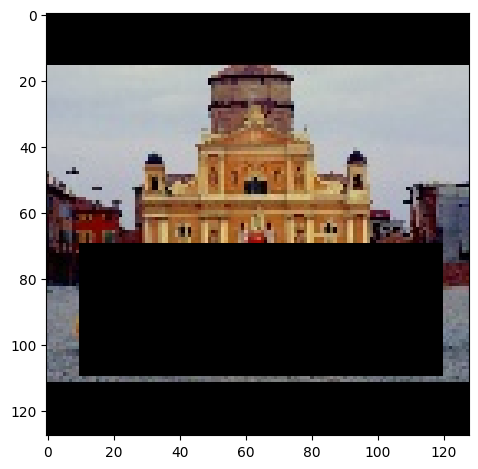

In [ ]:
from keras.utils import load_img
# load the image with the required shape
img = load_img('/content/valid/Car/05138.jpeg', target_size=(128, 128))
from keras.utils import img_to_array
from tensorflow import expand_dims
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
img = img / 255

img_numpy = img.numpy()
img_numpy[:,70:110,10:120,:] = 0

plt.imshow(img_numpy[0,:,:,:])

model.predict(img_numpy)

1/1 [==============================] - 0s 28ms/step


array([[0.05515522]], dtype=float32)

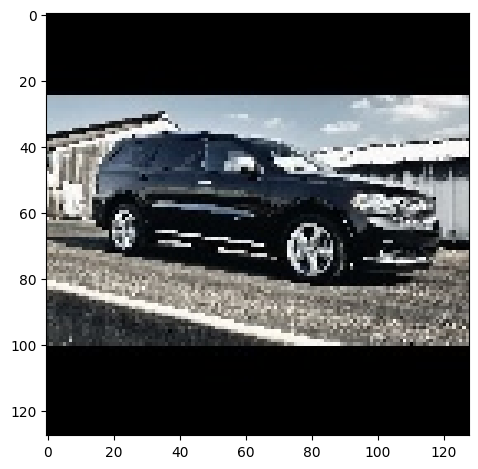

In [ ]:
from keras.utils import load_img
# load the image with the required shape
img = load_img('/content/valid/Truck/05157.jpeg', target_size=(128, 128))
from keras.utils import img_to_array
from tensorflow import expand_dims
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
img = img / 255

img_numpy = img.numpy()
# img_numpy[:,70:110,10:120,:] = 0

plt.imshow(img_numpy[0,:,:,:])

model.predict(img_numpy)